# 프로젝트: 한국어 데이터로 챗봇 만들기 C1 류지호

## Step 1. 데이터 수집하기 + 형태소 분석기 활용 토큰화

### 형태소 분석기 활용으로 한국어 특성에 맞는 토큰화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from tqdm import tqdm
import pickle
import time

# KoNLPy 형태소 분석기 설치
!pip install konlpy

from konlpy.tag import Mecab, Okt

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatbotData.csv")

# 데이터 로드
data = pd.read_csv('ChatbotData.csv')
print('데이터셋 크기 :', len(data))
print('데이터셋 구성 :', data.columns)
print('데이터셋 미리보기 :')
print(data.head())

# 형태소 분석기 초기화 (Mecab이 없으면 Okt 사용)
try:
    mecab = Mecab()
    print("Mecab 형태소 분석기를 사용합니다.")
    morpheme_analyzer = mecab
    
    def tokenize_morphemes(text):
        return mecab.morphs(text)
except:
    okt = Okt()
    print("Okt 형태소 분석기를 사용합니다.")
    morpheme_analyzer = okt
    
    def tokenize_morphemes(text):
        return okt.morphs(text)

# 한국어 특화 전처리 함수
def preprocess_korean_text(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 한글 자모 분리 현상 교정 (ㅋㅋㅋ, ㅎㅎㅎ 등의 처리)
    jamo_pattern = r'[ㄱ-ㅎㅏ-ㅣ]{2,}'
    sentence = re.sub(jamo_pattern, lambda x: x.group(0)[:2], sentence)
    
    # 이모티콘 정규화
    sentence = re.sub(r'[ㅋ]{2,}', 'ㅋㅋ', sentence)
    sentence = re.sub(r'[ㅎ]{2,}', 'ㅎㅎ', sentence)
    
    # 특수문자 제거 및 공백 정리 (한글, 영어, 숫자, 일부 특수문자만 유지)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    
    # 여러 공백을 하나의 공백으로 대체
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 구두점 앞에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 다시 여러 공백을 하나의 공백으로 대체
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    return sentence

# 형태소 분석 기반 토큰화 함수
def morpheme_tokenize(sentence):
    # 전처리 적용
    preprocessed = preprocess_korean_text(sentence)
    # 형태소 분석
    morphemes = tokenize_morphemes(preprocessed)
    # 형태소를 공백으로 구분하여 결합
    return ' '.join(morphemes)

# 질문과 답변 데이터 전처리 및 형태소 분석
questions_morpheme = []
answers_morpheme = []

print('형태소 분석 진행 중...')
for i in tqdm(range(len(data))):
    questions_morpheme.append(morpheme_tokenize(data.loc[i, 'Q']))
    answers_morpheme.append(morpheme_tokenize(data.loc[i, 'A']))

print('형태소 분석 완료!')
print('형태소 분석 후 질문 샘플:', questions_morpheme[:5])
print('형태소 분석 후 답변 샘플:', answers_morpheme[:5])

# 형태소 분석 결과 저장 (나중에 재사용 가능)
with open('morpheme_data.pkl', 'wb') as f:
    pickle.dump((questions_morpheme, answers_morpheme), f)

데이터셋 크기 : 11823
데이터셋 구성 : Index(['Q', 'A', 'label'], dtype='object')
데이터셋 미리보기 :
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
Mecab 형태소 분석기를 사용합니다.
형태소 분석 진행 중...


100%|██████████| 11823/11823 [00:04<00:00, 2493.36it/s]

형태소 분석 완료!
형태소 분석 후 질문 샘플: ['12 시 땡 !', '1 지망 학교 떨어졌 어', '3 박 4 일 놀 러 가 고 싶 다', '3 박 4 일 정도 놀 러 가 고 싶 다', 'PPL 심하 네']
형태소 분석 후 답변 샘플: ['하루 가 또 가 네요 .', '위로 해 드립니다 .', '여행 은 언제나 좋 죠 .', '여행 은 언제나 좋 죠 .', '눈살 이 찌푸려 지 죠 .']


## Step 2. 데이터 증강 + 전처리 개선

### 데이터 증강을 통한 학습 데이터 확장

### 한국어 특화 전처리 개선

In [2]:
# 데이터 증강 함수
def augment_data(questions, answers):
    augmented_questions = questions.copy()
    augmented_answers = answers.copy()
    
    print("데이터 증강 시작...")
    
    # 1. 일부 질문-답변 쌍의 순서를 뒤집어 데이터 증강
    for i in tqdm(range(len(questions))):
        # 복잡한 문장만 선택하여 증강 (단어 수가 3개 이상인 경우)
        if len(questions[i].split()) > 3 and len(answers[i].split()) > 3:
            # 답변이 질문이 될 수 있는 경우만 선택
            if not any(word in answers[i] for word in ['?', '까', '니까', '세요']):
                augmented_questions.append(answers[i])
                augmented_answers.append(questions[i])
    
    # 2. 유사 표현 추가 (일부 질문에 대해)
    question_prefixes = ['저는 ', '제가 ', '나는 ', '내가 ']
    for i in tqdm(range(len(questions))):
        original_q = questions[i]
        # 첫 단어가 '나' 또는 '저'로 시작하는 경우에만 적용
        if any(original_q.startswith(prefix) for prefix in ['나', '저']):
            for prefix in question_prefixes:
                if not original_q.startswith(prefix):
                    # 새로운 질문 생성
                    new_q = prefix + original_q[2:] if original_q[1] == ' ' else prefix + original_q[1:]
                    augmented_questions.append(new_q)
                    augmented_answers.append(answers[i])
    
    print(f"원본 데이터 크기: {len(questions)}")
    print(f"증강 후 데이터 크기: {len(augmented_questions)}")
    
    return augmented_questions, augmented_answers

# 데이터 증강 적용
questions_augmented, answers_augmented = augment_data(questions_morpheme, answers_morpheme)

# 토크나이저 생성
print('토크나이저 생성 중... (시간이 다소 소요될 수 있습니다)')
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions_augmented + answers_augmented, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰 정의
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2  # 시작 토큰과 종료 토큰을 고려하여 +2

print('단어장의 크기 :', VOCAB_SIZE)
print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)

# 토크나이저 테스트
sample_string = questions_augmented[0]
tokenized_string = tokenizer.encode(sample_string)
print('원문 :', sample_string)
print('토큰화 :', tokenized_string)
print('디코딩 결과 :', tokenizer.decode(tokenized_string))

# 토크나이저 저장
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# 최대 문장 길이 설정
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이 초과 샘플 제거, 패딩 적용
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs)):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

print('토큰화 및 필터링 진행 중...')
questions_tokenized, answers_tokenized = tokenize_and_filter(questions_augmented, answers_augmented)
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions_tokenized)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers_tokenized)))

# 토큰화된 데이터 저장
np.save('questions_tokenized.npy', questions_tokenized)
np.save('answers_tokenized.npy', answers_tokenized)

데이터 증강 시작...


100%|██████████| 11823/11823 [00:00<00:00, 1048709.05it/s]


원본 데이터 크기: 11823
증강 후 데이터 크기: 20482
토크나이저 생성 중... (시간이 다소 소요될 수 있습니다)
단어장의 크기 : 7862
START_TOKEN의 번호 : [7860]
END_TOKEN의 번호 : [7861]
원문 : 12 시 땡 !
토큰화 : [3115, 172, 6061, 115]
디코딩 결과 : 12 시 땡 !
토큰화 및 필터링 진행 중...


100%|██████████| 20482/20482 [00:00<00:00, 26802.75it/s]


필터링 후의 질문 샘플 개수: 20480
필터링 후의 답변 샘플 개수: 20480


## Step 3. 모델 구성 및 개선

### 더 깊은 레이어와 더 큰 모델 차원

### 드롭아웃 비율 조정

### 임베딩 레이어 분리 및 개선

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

# 멀티헤드 어텐션 레이어 (개선: 어텐션 가중치 반환 추가)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

# 패딩 마스크 생성 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 개선된 인코더 레이어 (드롭아웃 비율 조정 가능)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 인코더 (임베딩 레이어 분리)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 트랜스포머 모델
def improved_transformer(vocab_size,
                        num_layers,
                        units,
                        d_model,
                        num_heads,
                        dropout,
                        name="improved_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 출력층 앞에 추가 레이어 (성능 향상)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Step 4. 모델 학습 + 검증 세트 도입

### 검증 세트 도입

### 조기 종료 

### 모델 체크포인트

### 학습률 동적 조정

Model: "improved_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12436480    inputs[0][0]                     
                                                                 enc_padding_ma

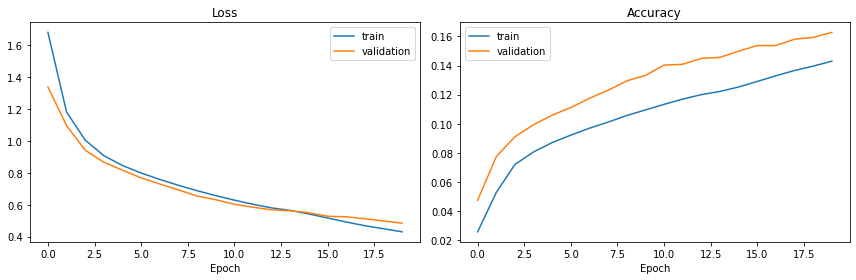

In [4]:
# 데이터셋 준비
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 데이터셋 분할 (검증 세트 추가)
train_size = int(0.9 * len(questions_tokenized))

# 학습 데이터셋
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]

# 검증 데이터셋
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# 학습 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_questions,
        'dec_inputs': train_answers[:, :-1]
    },
    {
        'outputs': train_answers[:, 1:]
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 검증 데이터셋 생성
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_questions,
        'dec_inputs': val_answers[:, :-1]
    },
    {
        'outputs': val_answers[:, 1:]
    },
))

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 하이퍼파라미터 설정
tf.keras.backend.clear_session()

# 하이퍼파라미터 (개선: 더 깊은 레이어와 더 큰 모델 차원)
NUM_LAYERS = 4  # 인코더와 디코더의 층의 개수 (2→4)
D_MODEL = 512   # 인코더와 디코더 내부의 입, 출력의 고정 차원 (256→512)
NUM_HEADS = 8   # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 1024    # 피드 포워드 신경망의 은닉층의 크기 (512→1024)
DROPOUT = 0.2   # 드롭아웃의 비율 (0.1→0.2)

# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

# 커스텀 학습률 스케줄 (학습률 동적 조정)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 학습률 설정
learning_rate = CustomSchedule(D_MODEL)

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 생성
model = improved_transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 모델 요약
model.summary()

# 콜백 정의 (조기 종료 및 모델 체크포인트)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint_path = "./checkpoints/transformer/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    monitor='val_loss')

# 학습률 감소 콜백
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

# 모델 학습
EPOCHS = 20
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, cp_callback, reduce_lr],
    verbose=1
)

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 최종 모델 저장
model.save_weights('./checkpoints/transformer/final_model')

## Step 5. 모델 평가 + 빔 서치 디코딩 구현

### 빔 서치 디코딩 구현

### 대화 맥락을 고려한 응답 생성

### BLEU 점수 도입 (객관적 평가 지표)

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



===== 테스트 문장 평가 =====
입력 : 안녕하세요
출력 (그리디 디코딩) : 저 도 요 .
출력 (빔 서치) : 저 랑 한 잔 해요 .
입력 : 오늘 날씨가 어때요?
출력 (그리디 디코딩) : 건강 에 좋 은 습관 이 네요 .
출력 (빔 서치) : 맛있 는 거 드세요 .
입력 : 내일 시간 있으세요?
출력 (그리디 디코딩) : 저 도 요 !
출력 (빔 서치) : 저 랑 놀 아요 .
입력 : 영화 보러 갈래요?
출력 (그리디 디코딩) : 친구 가 좋 아 하 나 봐요 .
출력 (빔 서치) : 친구 한테 부탁 해 보 세요 .
입력 : 맛있는 음식점 추천해주세요
출력 (그리디 디코딩) : 같이 갈 친구 가 있 으면 좋 겠 네요 .
출력 (빔 서치) : 축하 해요 !
모델 평가 중...
입력 : 죽을거 같네
출력 (그리디 디코딩) : 마음 이 복잡 하 겠 어요 .
입력 : 내일 시험이야
출력 (그리디 디코딩) : 건강 에 좋 은 습관 이 네요 .
입력 : 정말.내 자신이 싫다
출력 (그리디 디코딩) : 마음 이 복잡 하 겠 어요 .
입력 : 이별후 네달째
출력 (그리디 디코딩) : 마음 이 복잡 한가 봐요 .
입력 : 쌍커풀 해볼까
출력 (그리디 디코딩) : 건강 에 좋 은 습관 이 네요 .
입력 : 내 생각 하나만 바꾸면 편할텐데.
출력 (그리디 디코딩) : 저 도 요 !
입력 : 어떻게 살아가야 할까
출력 (그리디 디코딩) : 저 도 궁금 하 네요 .
입력 : 발 아파
출력 (그리디 디코딩) : 비 가 오 려나요 .
입력 : 썸 타는 것도 귀찮아.
출력 (그리디 디코딩) : 썸 타 는 중 인데 사귀 는 사이 로 바쁘 면 될까요 ?
입력 : 좋아하는 애랑 전화하면
출력 (그리디 디코딩) : 사람 마다 정도 는 다르 지만 사귀 고 난 후 가 좋 겠 어요 .
평가 진행: 10/100
입력 : 뿌염해야지
출력 (그리디 디코딩) : 저 도 밥 먹 고 싶 어요
입력 : 여행 왔는데 좋아하는 선물로 뭐가 괜찮을까?
출력 (그리디 디코딩) : 먼저 다가가 보 세요 .


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_

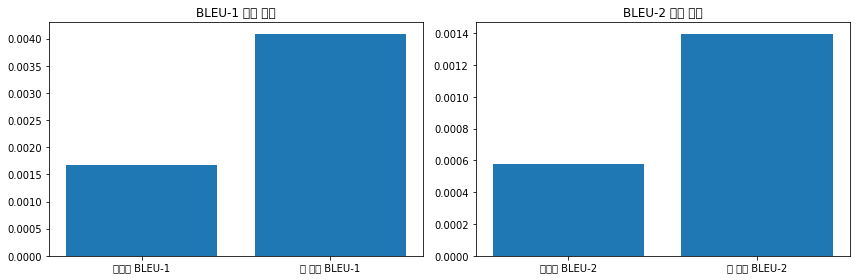


===== 대화 인터페이스 =====
챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.
사용자: 안녕 내 이름은 류지호야.
챗봇: 돈 버 는 게 쉽 지 않 아요 .
사용자: 맞아. 돈 버는게 쉽지 않지. 그래서 나는 취업을 위해 AI에 대해 공부하고 있어.
챗봇: 내 가 좋 아 하 는 사람 이 나 좋 아 하 는 것 같 아
사용자: 연애와 결혼도 취업만큼이나 중요하지. 넌 돈 버는 것만큼이나 연애에도 관심이 많구나?
챗봇: 잘 하 실 거 예요 !
사용자: 내 걱정 말고 너나 잘해. 넌 더 똑똑해질 필요가 있어보여.
챗봇: 전 여친 생일 이 야
사용자: 갑자기?
챗봇: 사랑 에 빠졌 나 봐요 .
대화가 종료되었습니다.


In [5]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# NLTK 다운로드
import nltk
nltk.download('punkt')

# 빔 서치를 활용한 향상된 문장 생성 함수
def beam_search_decoder(sentence, beam_width=5, max_length=MAX_LENGTH):
    # 입력 문장 전처리
    sentence = preprocess_korean_text(sentence)
    
    # 형태소 분석 적용
    sentence = morpheme_tokenize(sentence)
    
    # 정수 인코딩 후 시작 토큰과 종료 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 초기 상태: 시작 토큰
    initial_state = tf.expand_dims(START_TOKEN, 0)
    
    # 초기 빔: [(시퀀스, 점수)]
    beams = [(initial_state, 0.0)]
    
    # 빔 서치 반복
    for _ in range(max_length):
        candidates = []
        
        # 현재 빔의 각 시퀀스에 대해
        for seq, score in beams:
            # 종료 토큰이 이미 있으면 후보에 추가하고 계속
            if END_TOKEN[0] in seq[0][1:]:
                candidates.append((seq, score))
                continue
            
            # 모델 예측
            predictions = model(inputs=[sentence, seq], training=False)
            predictions = predictions[:, -1, :]
            
            # 상위 beam_width개 토큰 선택
            top_k_values, top_k_indices = tf.nn.top_k(
                tf.nn.softmax(predictions[0]), k=beam_width)
            
            # 각 후보에 대해
            for i in range(beam_width):
                # 새 토큰 추가
                new_seq = tf.concat([seq, tf.reshape(top_k_indices[i], (1, 1))], axis=-1)
                # 로그 확률 합산 (점수)
                new_score = score + tf.math.log(top_k_values[i])
                candidates.append((new_seq, new_score))
        
        # 후보들 중 상위 beam_width개 선택
        candidates.sort(key=lambda x: x[1], reverse=True)
        beams = candidates[:beam_width]
        
        # 모든 빔이 종료 토큰을 가지면 중단
        if all(END_TOKEN[0] in seq[0][1:] for seq, _ in beams):
            break
    
    # 최고 점수 시퀀스 선택
    best_seq, _ = beams[0]
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    best_seq = tf.squeeze(best_seq, axis=0)
    predicted_sentence = tokenizer.decode(
        [i for i in best_seq if i < tokenizer.vocab_size and i != START_TOKEN[0]])
    
    return predicted_sentence

# 기존 디코더 추론 함수 (비교용)
def decoder_inference(sentence):
    # 입력 문장 전처리
    sentence = preprocess_korean_text(sentence)
    
    # 형태소 분석 적용
    sentence = morpheme_tokenize(sentence)
    
    # 정수 인코딩 후 시작 토큰과 종료 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지 예측한 출력 시퀀스
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 현재 예측한 단어가 종료 토큰이면 for문 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어를 output_sequence에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

# 기존 문장 생성 함수 (비교용)
def sentence_generation(sentence):
    # 입력 문장에 대해 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받음
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size and i != START_TOKEN[0]])
    
    print('입력 : {}'.format(sentence))
    print('출력 (그리디 디코딩) : {}'.format(predicted_sentence))
    
    return predicted_sentence

# 향상된 문장 생성 함수 (빔 서치 사용)
def improved_sentence_generation(sentence):
    # 그리디 디코딩 결과
    greedy_result = sentence_generation(sentence)
    
    # 빔 서치 디코딩 결과
    beam_result = beam_search_decoder(sentence, beam_width=5)
    
    print('출력 (빔 서치) : {}'.format(beam_result))
    
    return beam_result

# BLEU 점수 계산 함수
def calculate_bleu(reference, candidate):
    # 토큰화
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    
    # BLEU 점수 계산 (스무딩 적용)
    smoothie = SmoothingFunction().method1
    try:
        bleu1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    except:
        bleu1, bleu2 = 0, 0
    
    return bleu1, bleu2

# 대화 맥락을 고려한 챗봇 인터페이스
def interactive_chat(max_turns=5):
    # 대화 기록
    conversation_history = []
    
    print("챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.")
    
    for turn in range(max_turns):
        # 사용자 입력
        user_input = input("사용자: ")
        
        if user_input.lower() == '종료':
            print("대화를 종료합니다.")
            break
        
        # 대화 기록에 사용자 입력 추가
        conversation_history.append(user_input)
        
        # 최근 대화 맥락 구성 (최대 3턴)
        if len(conversation_history) > 1:
            context = " ".join(conversation_history[-3:])
        else:
            context = user_input
        
        # 챗봇 응답 생성 (빔 서치 사용)
        bot_response = beam_search_decoder(context)
        
        # 대화 기록에 챗봇 응답 추가
        conversation_history.append(bot_response)
        
        print(f"챗봇: {bot_response}")
    
    print("대화가 종료되었습니다.")

# 모델 평가
def evaluate_model():
    # 테스트 세트 생성 (원본 데이터에서 랜덤 샘플링)
    np.random.seed(42)
    test_indices = np.random.choice(len(data), 100, replace=False)
    test_questions = [data.loc[i, 'Q'] for i in test_indices]
    test_answers = [data.loc[i, 'A'] for i in test_indices]
    
    # 평가 지표 저장
    greedy_bleu1_scores = []
    greedy_bleu2_scores = []
    beam_bleu1_scores = []
    beam_bleu2_scores = []
    
    print("모델 평가 중...")
    
    for i, (question, reference) in enumerate(zip(test_questions, test_answers)):
        # 그리디 디코딩
        greedy_result = sentence_generation(question)
        
        # 빔 서치 디코딩
        beam_result = beam_search_decoder(question)
        
        # BLEU 점수 계산
        greedy_bleu1, greedy_bleu2 = calculate_bleu(reference, greedy_result)
        beam_bleu1, beam_bleu2 = calculate_bleu(reference, beam_result)
        
        greedy_bleu1_scores.append(greedy_bleu1)
        greedy_bleu2_scores.append(greedy_bleu2)
        beam_bleu1_scores.append(beam_bleu1)
        beam_bleu2_scores.append(beam_bleu2)
        
        if (i+1) % 10 == 0:
            print(f"평가 진행: {i+1}/100")
    
    # 결과 요약
    print("\n===== 평가 결과 =====")
    print(f"그리디 디코딩 평균 BLEU-1: {np.mean(greedy_bleu1_scores):.4f}")
    print(f"그리디 디코딩 평균 BLEU-2: {np.mean(greedy_bleu2_scores):.4f}")
    print(f"빔 서치 디코딩 평균 BLEU-1: {np.mean(beam_bleu1_scores):.4f}")
    print(f"빔 서치 디코딩 평균 BLEU-2: {np.mean(beam_bleu2_scores):.4f}")
    
    # 결과 시각화
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.bar(['그리디 BLEU-1', '빔 서치 BLEU-1'], 
            [np.mean(greedy_bleu1_scores), np.mean(beam_bleu1_scores)])
    plt.title('BLEU-1 점수 비교')
    
    plt.subplot(1, 2, 2)
    plt.bar(['그리디 BLEU-2', '빔 서치 BLEU-2'], 
            [np.mean(greedy_bleu2_scores), np.mean(beam_bleu2_scores)])
    plt.title('BLEU-2 점수 비교')
    
    plt.tight_layout()
    plt.show()

# 테스트 문장으로 모델 평가
test_sentences = [
    '안녕하세요',
    '오늘 날씨가 어때요?',
    '내일 시간 있으세요?',
    '영화 보러 갈래요?',
    '맛있는 음식점 추천해주세요'
]

print("\n===== 테스트 문장 평가 =====")
for test_sentence in test_sentences:
    improved_sentence_generation(test_sentence)

# 전체 모델 평가 실행
evaluate_model()

# 대화 인터페이스 실행
print("\n===== 대화 인터페이스 =====")
interactive_chat()